# Classification Using A CNN (and CIFAR-10)
---

In this notebook we implement a convolutional neural network to classify low quality images (from the CIFAR-10) dataset where each entry belongs to exactly one of 10 classes.

In [58]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import datetime

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cuda:0


In [11]:
# Get training and validation datasets from PyTorch
# Pass both to dataloaders for sampling batches. 

data_path = 'C:\\Users\\Kyle\\Documents\\GitHub\\data\\'
# Define a transform to normalize the 3 channels of each image to 0.5 and 0.5 mean, std dev.
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(data_path, train=True, download=True,  transform=transform)
val_set = torchvision.datasets.CIFAR10(data_path, train=False, download=True,  transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Define CNN

In [12]:
###
# Define CNN
###

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        # take 3x32x32 --> 6x32x32 
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding=1)
        # downsample 6x32x32 --> 6x16x16
        self.pool1 = nn.MaxPool2d(2, 2)
        # convolve 6x16x16 --> 8x16x16
        self.conv2 = nn.Conv2d(6, 8, kernel_size=3, padding=1)
        # convolve 8x16x16 --> 8x8x8
        self.pool2 = nn.MaxPool2d(2, 2)
        # flatten 8x8x8 --> 64x1
        self.fc1 = nn.Linear(8*8*8, 64)
        # flatten 64x1 --> 32x1
        self.fc2 = nn.Linear(64, 32)
        # flatten 64x1 --> 32x1
        self.fc3 = nn.Linear(32, 10)
        # flatten 32x1 --> 10x1
        
    def forward(self, x):
        # Apply convolution, activation function, and pooling to input
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # reshape x to match first linear layer
        x = x.view(-1, 8*8*8)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [60]:
# === Helper Functions, members ===

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show image 
def imshow(img):
    # display an image
    img = img / 2 + 0.5 # unnormalize image to [0,1]
    npimg = img.numpy()
    # Display image by reordering channels to match pyplot's expectation
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
# Validation loop
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("validate", val_loader)]:
        correct_pred, total = 0, 0
        # disable tracking of operations 
        with torch.no_grad():
            for imgs, labels in loader:
                # convert tensors to device
                imgs = imgs.to(device)
                labels = labels.to(device)
                print('inshape: ', imgs.shape)
                y_preds = model(imgs)
                _, predicted = torch.max(y_preds, dim=1)
                total += labels.shape[0]
                # compare agreements between predicted and labels, sum and add to running total. 
                correct_pred += int((predicted==labels).sum())
        print(f'Accuracy: {name} {correct_pred/total:.3f}')
        
    return correct_pred/total


# Training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    # loop over epochs
    
    best_accuracy = 0.0
    
    running_loss = []
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        
        # iter over training batch
        for imgs, labels in train_loader:
            # convert tensors to device
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            y_pred = model(imgs)
            
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        running_loss.append(loss_train)
                
        # display results of network. Save model if better accuracy rate is achieved. 
        if epoch % 10 == 0 or epoch == 1: 
            loss = loss_train / len(train_loader)
            print(f'{datetime.datetime.now()} Epoch: {epoch}, Training loss: {loss:.3f}')
            
            accuracy = validate(model, train_loader, val_loader)
            
            if accuracy > best_accuracy:
                # save model 
                print("Saving model !")
                data_path = 'C:\\Users\\Kyle\\Documents\\GitHub\\Learning-Repo\\PyTorch\\models\\'
                torch.save(model.state_dict(), data_path+'_n_'+ str(n_epochs+1) +'cifar_10_test.pt')
                best_accuracy = accuracy
                
    return running_loss
            

In [46]:
model = CNN()
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

training_loop(300, opt, model, loss_fn, train_loader,val_loader)

2020-10-18 12:23:50.196626 Epoch: 1, Training loss: 1.722
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 32, 32])
inshape:  torch.Size([64, 3, 3

KeyboardInterrupt: 

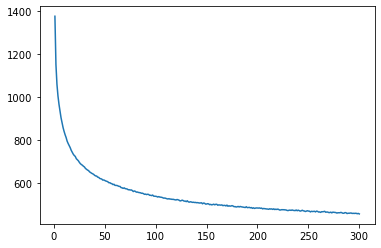

AxesImage(54,36;334.8x217.44)
True label: cat Predicted: frog
AxesImage(54,36;334.8x217.44)
True label: ship Predicted: ship
AxesImage(54,36;334.8x217.44)
True label: ship Predicted: ship
AxesImage(54,36;334.8x217.44)
True label: plane Predicted: ship
AxesImage(54,36;334.8x217.44)
True label: frog Predicted: deer


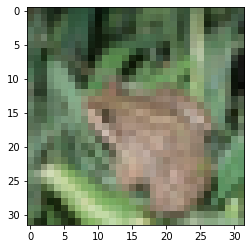

In [61]:
# Load trained model
data_path = 'C:\\Users\\Kyle\\Documents\\GitHub\\Learning-Repo\\PyTorch\\models\\'
torch.save(model.state_dict(), data_path+'_n_301cifar_10_test.pt')
model = CNN()
model.load_state_dict(torch.load('C:\\Users\\Kyle\\Documents\\GitHub\\Learning-Repo\\PyTorch\\models\\_n_301cifar_10_test.pt'))
model.eval()

for i in range(5):
    img, label = val_set[i]
    
    with torch.no_grad():
        _, pred = torch.max(model(img.unsqueeze(0)), dim=1)
        imshow(img)
        print(f'True label: {classes[label]} Predicted: {classes[pred]}')

In [63]:
print(imshow(val_set[4]))

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'